In [23]:
import pandas as pd
import numpy as np
from sklearn.metrics import *
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.linear_model import LogisticRegression
import random
import matplotlib.pyplot as plt

def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)

set_seed(1)

In [63]:
def prepare_data(dataset_path_train = None,dataset_path_test = None):
    if (dataset_path_train is None or dataset_path_test is None):
        raise RuntimeException("Error! Dataset must be provided")
    train = pd.read_csv(dataset_path_train)
    test = pd.read_csv(dataset_path_test)
    
    y_train = train['label']
    y_test = test['label']
    
    features = []
    for feat in train.columns.values:
        if 'lex' in feat:
            features.append(feat)
    features.extend(['roberta_prediction', 'syntax_ari', 'social_karma'])
    
    X_train = train[features]
    X_test = test[features]
    
    return X_train, y_train, X_test, y_test

def evaluate(test_labels, y_pred):
    acc = accuracy_score(test_labels, y_pred)
    rec = recall_score(test_labels, y_pred, zero_division=1)
    prec = precision_score(test_labels, y_pred, zero_division=1)
    f1 = f1_score(test_labels, y_pred, zero_division=1)
    print("Accuracy: ", acc)
    print("Recall: ", rec)
    print("Precision: ", prec)
    print("F1: ", f1)

## Grid Search

### Logistic regression

In [65]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

X_train, y_train, X_test, y_test = prepare_data(dataset_path_train = 'train_pred_roberta_our_scraped_data.csv', dataset_path_test = 'test_pred_roberta_our_scraped_data.csv')
#sclr = StandardScaler()
#X_train = sclr.fit_transform(X_train)
#X_test = sclr.transform(X_test)
hp = {
        'solver': ['liblinear', 'newton-cg', 'lbfgs'],
        'penalty': ['l2', 'elasticnet'],
        'C': [0.1, 1, 10],
    }
gs_model = GridSearchCV(LogisticRegression(max_iter=1000000), hp, n_jobs=-1, scoring='f1', verbose=4)
gs_model.fit(X_train, y_train)
    
model = LogisticRegression(max_iter=1000000,**gs_model.best_params_)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
evaluate(y_test, y_pred)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


C:\Users\38599\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.89667657 0.89531903 0.89567113        nan        nan        nan
 0.9004022  0.90005368 0.90005368        nan        nan        nan
 0.89858957 0.89829633 0.89858957        nan        nan        nan]
  warnings.warn(


Accuracy:  0.8223776223776224
Recall:  0.907859078590786
Precision:  0.7827102803738317
F1:  0.8406524466750314


In [66]:
gs_model.best_params_

{'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}

In [67]:
cdf = pd.DataFrame(model.coef_.transpose(), X_train.columns.values, columns=['coefficient'])
cdf.sort_values(by='coefficient',  key=abs, ascending=False)

,coefficient
roberta_prediction,4.169896
lex_dal_min_pleasantness,-1.091760
lex_dal_avg_pleasantness,-1.011313
lex_dal_min_activation,-0.964860
lex_dal_max_pleasantness,-0.548430
...,...
lex_liwc_discrep,-0.006720
lex_liwc_Authentic,-0.005456
lex_liwc_power,0.002345
lex_liwc_WC,0.001997


In [93]:
import phik
def pairs(X, threshold):
    corr =  X.phik_matrix(interval_cols=X.columns)
    columns = corr.columns
    high_corr = dict()
    feature_corr_n = dict.fromkeys(X.columns, 0)
    for column1 in columns:
        for column2 in columns:
            value = corr[column1][column2]
            if value > threshold and column1 != column2 and (column2, column1) not in high_corr:
                high_corr[(column1,column2)] = value
    return high_corr

In [95]:
X_train, y_train, X_test, y_test = prepare_data(dataset_path_train = 'train_pred_roberta_our_scraped_data.csv', dataset_path_test = 'test_pred_roberta_our_scraped_data.csv')
high_corr = pairs(X_train, 0.85)
high_corr

{('lex_liwc_Dic', 'lex_liwc_function'): 0.8742640297022712,
 ('lex_liwc_function', 'lex_dal_min_imagery'): 0.8719230724812735,
 ('lex_liwc_pronoun', 'lex_liwc_ppron'): 0.8786921613950186,
 ('lex_liwc_you', 'lex_dal_min_imagery'): 0.9533623568286118,
 ('lex_liwc_affect', 'lex_liwc_negemo'): 0.8770119365967479,
 ('lex_liwc_affect', 'lex_liwc_anger'): 0.8690108478796704,
 ('lex_liwc_negemo', 'lex_liwc_sad'): 0.8842411498300708,
 ('lex_liwc_AllPunc', 'lex_liwc_QMark'): 0.8678308171716569,
 ('lex_liwc_AllPunc', 'lex_liwc_OtherP'): 0.9129396114583693}

In [121]:
X_train, y_train, X_test, y_test = prepare_data(dataset_path_train = 'train_pred_roberta_our_scraped_data.csv', dataset_path_test = 'test_pred_roberta_our_scraped_data.csv')
to_drop = ['lex_liwc_ppron', 'lex_liwc_AllPunc', 'lex_dal_min_imagery', 'lex_liwc_negemo']
X_train = X_train.drop(columns=to_drop)
X_test = X_test.drop(columns=to_drop)

In [122]:
model = LogisticRegression(max_iter=1000000,**gs_model.best_params_)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
evaluate(y_test, y_pred)

Accuracy:  0.8223776223776224
Recall:  0.907859078590786
Precision:  0.7827102803738317
F1:  0.8406524466750314


0.9037557480389167
102


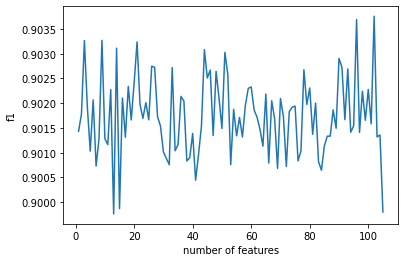

In [123]:
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k = 1
f1s = []
ks = []
best = 0
kbest = 0
while k <= 105:
    cv = KFold(n_splits=5, shuffle=True)
    scores = cross_val_score(model, X_train_k, y_train, cv=cv, n_jobs=-1, scoring='f1')
    f1 = sum(scores)/len(scores)
    ks.append(k)
    f1s.append(f1)
    if best < f1: 
        best = f1
        kbest = k
    k += 1
    
plt.plot(ks, f1s)
plt.xlabel('number of features')
plt.ylabel('f1')
#plt.ylim([0.83, 0.85])
print(best)
print(kbest)

In [124]:
X_train, y_train, X_test, y_test = prepare_data(dataset_path_train = 'train_pred_roberta_our_scraped_data.csv', dataset_path_test = 'test_pred_roberta_our_scraped_data.csv')
sel = SelectKBest(k=kbest)
X_train_k = sel.fit_transform(X_train, y_train)
X_test_k = sel.transform(X_test)
model = LogisticRegression(max_iter=1000000,**gs_model.best_params_)
model.fit(X_train_k, y_train)
y_pred = model.predict(X_test_k)
evaluate(y_test, y_pred)

Accuracy:  0.8223776223776224
Recall:  0.907859078590786
Precision:  0.7827102803738317
F1:  0.8406524466750314


In [144]:
from sklearn.feature_selection import f_classif
sdf = pd.DataFrame(f_classif(X_train, y_train)[0].transpose(), X_train.columns.values, columns=['ANOVA f-value'])
print(sdf.sort_values(by='ANOVA f-value',  key=abs, ascending=False)[0:kbest].to_string())

                          ANOVA f-value
roberta_prediction          4762.131018
lex_liwc_Tone                665.667517
lex_liwc_Clout               552.525167
lex_liwc_i                   541.606144
lex_liwc_negemo              502.542804
lex_dal_min_pleasantness     275.252875
lex_liwc_Authentic           232.533821
lex_liwc_posemo              224.200886
lex_liwc_anx                 205.861266
lex_liwc_social              189.150052
lex_liwc_Analytic            185.749398
lex_liwc_Dic                 175.701906
lex_liwc_function            168.672851
lex_liwc_anger               142.856293
lex_liwc_you                 131.546897
lex_liwc_feel                115.778067
lex_liwc_sad                 113.622894
lex_liwc_Apostro             103.334092
lex_liwc_ppron               103.189466
lex_liwc_focuspresent        102.662869
lex_liwc_negate              102.503145
lex_liwc_pronoun             101.455718
lex_liwc_risk                 93.607490
lex_liwc_affiliation          92.475708
